In [35]:
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib.image as mpimg
import numpy as np
from scipy import interpolate
import datetime
import pandas as pd
import matplotlib
%matplotlib inline

In [6]:
# Minute data, 4 Schools
mindata, dc = np.loadtxt('/Users/kawebb/P411_git/MinuteData/DeepCoveNew.txt', unpack=True)
jb = np.loadtxt('/Users/kawebb/P411_git/MinuteData/JamesBayNew.txt', usecols=([1]), unpack=True)
jm = np.loadtxt('/Users/kawebb/P411_git/MinuteData/JohnMuirNew.txt', usecols=([1]), unpack=True)
uvic = np.loadtxt('/Users/kawebb/P411_git/MinuteData/UVicISCNew.txt', usecols=([1]), unpack=True)

In [15]:
# Hourly data, many stations
# One-hour resolution temperature data is taken from the same network of 35 stations. 
# Data is on an even time grid, from 2009-01-01 08:00 UTC, with each row representing 
# a time, and each column a station. The first two rows are the longitude (degrees E) 
# and latitude (degrees N) of each station.
hourfile = '/Users/kawebb/P411_git/AllHourly.txt'
hourdata = np.loadtxt(hourfile)
data = hourdata[:,2:]
lng = hourdata[:,:1][:,0] - 360.  # -360 to fix that stations (0 to 360), coast (-180, 180).
lat = hourdata[:,1:2][:,0]

# deep cove is 0 (2?) (assignment 5)

- john muir - hourdata 15
- james bay - hourdata 14
- uvic - hourdata 32
- deep cove - hourdata 6

In [16]:
# Coastline
# 1 degree of latitude is 60 nautical miles, but 1 degree of longitude is only 60*cos(lat) 
# nautical miles, so it is useful to scale your x and y axis so the aspect ratio is 
# [1 cos(lat)], where "lat" is some latitude that is on the center of your plot. This area 
# is small enough that this approximation will be good enough - for larger areas you need 
# to choose a projection from a sphere onto a map (i.e. the "Mercator", "Azimuthal" etc projections).
coastfile = '/Users/kawebb/P411_git/Coast.txt'  # longitudes followed by latitudes
coasts = np.loadtxt(coastfile)
cstlng = coasts[:len(coasts)/2]
cstlat = coasts[len(coasts)/2:]

### It wouldn't work to ignore the whole set of data if one measurement if nan, only leaves 25 measurements

### perhaps interpolate data points?


## ideas:
- temperature differences inland vs coasts, seasonal
- seasonal variances
- east west
- yearly fluctuations

### power spactra
- correlations every 24h, 1yr etc
  - combine spectra to reduce noise and get  clearer peak
  - bandpass filtering
- variation in temperature (amplitude) varies more in summer than winter
- average summer temperature, winter, yearly -> linear equation, fit to majority of data

### to keep in mind:
- more data on coast than inland, how to keep track of percision?

In [17]:
# The data sets start on 1 Jan 2009 a minute after midnight local, or at 08:00 UTC = 733408.333.
d = datetime.date(2012,1,1)
#d.toordinal
#d.fromordinal(733408)

tstart = 733408.333
hours = np.arange(tstart, tstart+len(data[0])/24., 1./24.)  # step size is every hour
d.fromordinal(int(hours[0])), d.fromordinal(int(hours[-1]))  # three years worth of data

(datetime.date(2009, 1, 1), datetime.date(2012, 1, 1))

In [10]:
# Remove nan values from arrays
data0 = data[0]
data0 = data0[~np.isnan(data0)]
hours0 = hours[~np.isnan(data0)]

# how jody does it in assignment 2
mask = np.isfinite(np.sum(data, axis=0))
mask2d = np.ones(data.shape, dtype=np.bool)
mask2d[:,] = mask

datam = data[mask2d]
hoursr = hours[mask]

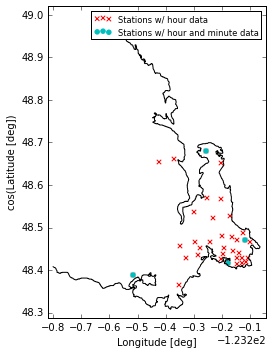

In [117]:
#latexify()
fig, axs = plt.subplots(1,1, figsize=(5,5))
axs.plot(cstlng, cstlat, '-k')
axs.scatter(lng, lat, marker='x', color='r', label='Stations w/ hour data')
i=[6, 15, 14, 32]
axs.scatter(lng[i], lat[i], marker='o', color='c', label='Stations w/ hour and minute data')

axs.set_xlabel(r'Longitude [deg]') ; axs.set_ylabel(r'cos(Latitude [deg])')
axs.set_xlim(np.min(cstlng)-0.02, np.max(cstlng)+0.02)
axs.set_ylim(np.min(cstlat)-0.02, np.max(cstlat)+0.02)
axs.set_aspect(1/np.cos(48.6*np.pi/180.))
plt.tight_layout()
plt.legend(fontsize='small')
#plt.savefig('map_stations.png')
plt.show()

0.000771824910175


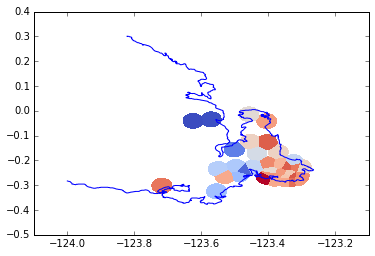

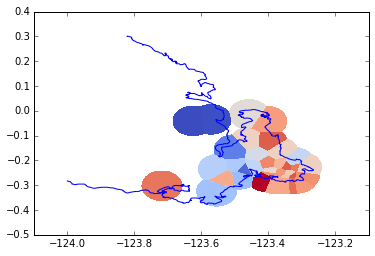

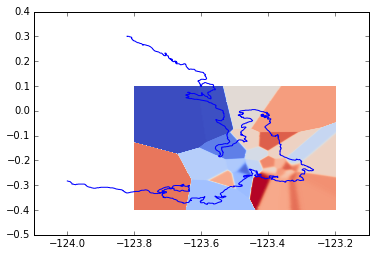

In [12]:
# Make grid - Smallest distance between points is lateral, 0.234 deg
# np.meshgrid makes a MxN array out of x (N-vector) and y (M-vector)
xi = np.linspace(-123.2, -123.8, 1000)
yi = np.linspace(-0.4, 0.1, 1000)
X, Y = np.meshgrid(xi, yi)

z = data[:,-1]  # last measurement

nx = len(xi)
ny = len(yi)
Zi = np.zeros((ny,nx))
sigma = gs

for sigma in [gs, 2*gs, 10*gs]:
    for i in range(nx):
        for j in range(ny):
            rsq = (xi[i] - lng)**2 + (yi[j] - clat)**2
            w = np.exp(-rsq/2./sigma**2)
            w /= np.sum(w)
            Zi[j,i] = np.sum(w*z)    

    plt.scatter(lng, clat)
    plt.plot(cstlng, ccstlat)
    pcm = plt.pcolormesh(X, Y, np.ma.masked_invalid(Zi), cmap='coolwarm')
    plt.show()  

/Users/kawebb/venv/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


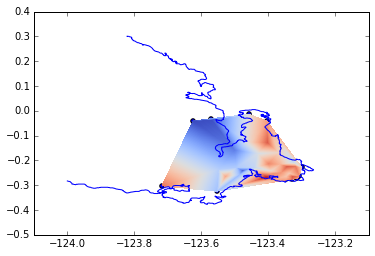

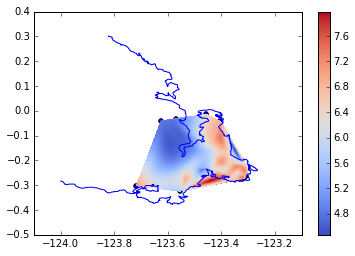

In [13]:
x = lng
y = clat

zi = mlab.griddata(x,y,z,xi,yi,interp='linear')
plt.scatter(lng, clat)
plt.plot(cstlng, ccstlat)
pcm = plt.pcolormesh(X, Y, np.ma.masked_invalid(zi), cmap='coolwarm')
plt.show()

Xx = np.vstack((x,y)).T
zi = interpolate.griddata(Xx,z,(X,Y),method='cubic')
plt.scatter(lng, clat)
plt.plot(cstlng, ccstlat)
pcm = plt.pcolormesh(X, Y, np.ma.masked_invalid(zi), cmap='coolwarm')
plt.colorbar()
plt.show()

In [ ]:
# Power spectra of hourly data, dc
Nfft = 1024*4
dt = 1./24.
args = {'NFFT':Nfft, 'Fs':1./dt, 'noverlap':Nfft/2., 'window':mlab.window_hanning}

dc = data[0,:]
dc = dc[np.isfinite(dc)]

pp, f = mlab.psd(dc, **args)

plt.loglog(f, pp, label='Power spectra')
pltxlabel('f [Hz]') ; plt.ylabel(r'$G_{xx}(f)\ \ [(^oC)^2 Hz^{-1}]$')

In [55]:
SPINE_COLOR = 'gray'
def latexify(fig_width=None, fig_height=None, columns=1):
    """
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """
    assert(columns in [1,2])
    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches
    if fig_height is None:
        golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES
    params = {'backend': 'ps',
              #'text.latex.preamble': ['\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'text.fontsize': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              #'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }
    matplotlib.rcParams.update(params)
    
def format_axes(ax, xlabel, ylabel):
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)
    return ax